In [1]:
import pandas as pd
import numpy as np

In [2]:
#Load ML Packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, cross_val_predict

# Data Collection

In [5]:
df=pd.read_excel('Data-reduced.xlsx')

In [8]:
# Keeping the rows with 1 and NaN, these are the rows which are supposed to be analyzed
df = df[(df['Check FC'] == 1) | (df['Check FC'].isna())]


In [10]:
# Getting rid of the first column
df=df[['DESCRIPTION','Herstellung']]
df.head()

,DESCRIPTION,Herstellung
0,.Smoothfood Brot 48x70g,"Brot, übrige"
1,"""Apfel Boskoop ""Thurgauer""",Äpfel CH
2,"""Aprikosen ""ROUGECOT""",Aprikosen
3,"""Aprikosen ""VANILLACOT""",Aprikosen
4,"""Aprikosen AAA ""Walliser""",Aprikosen


# Exploratory Data Analysis

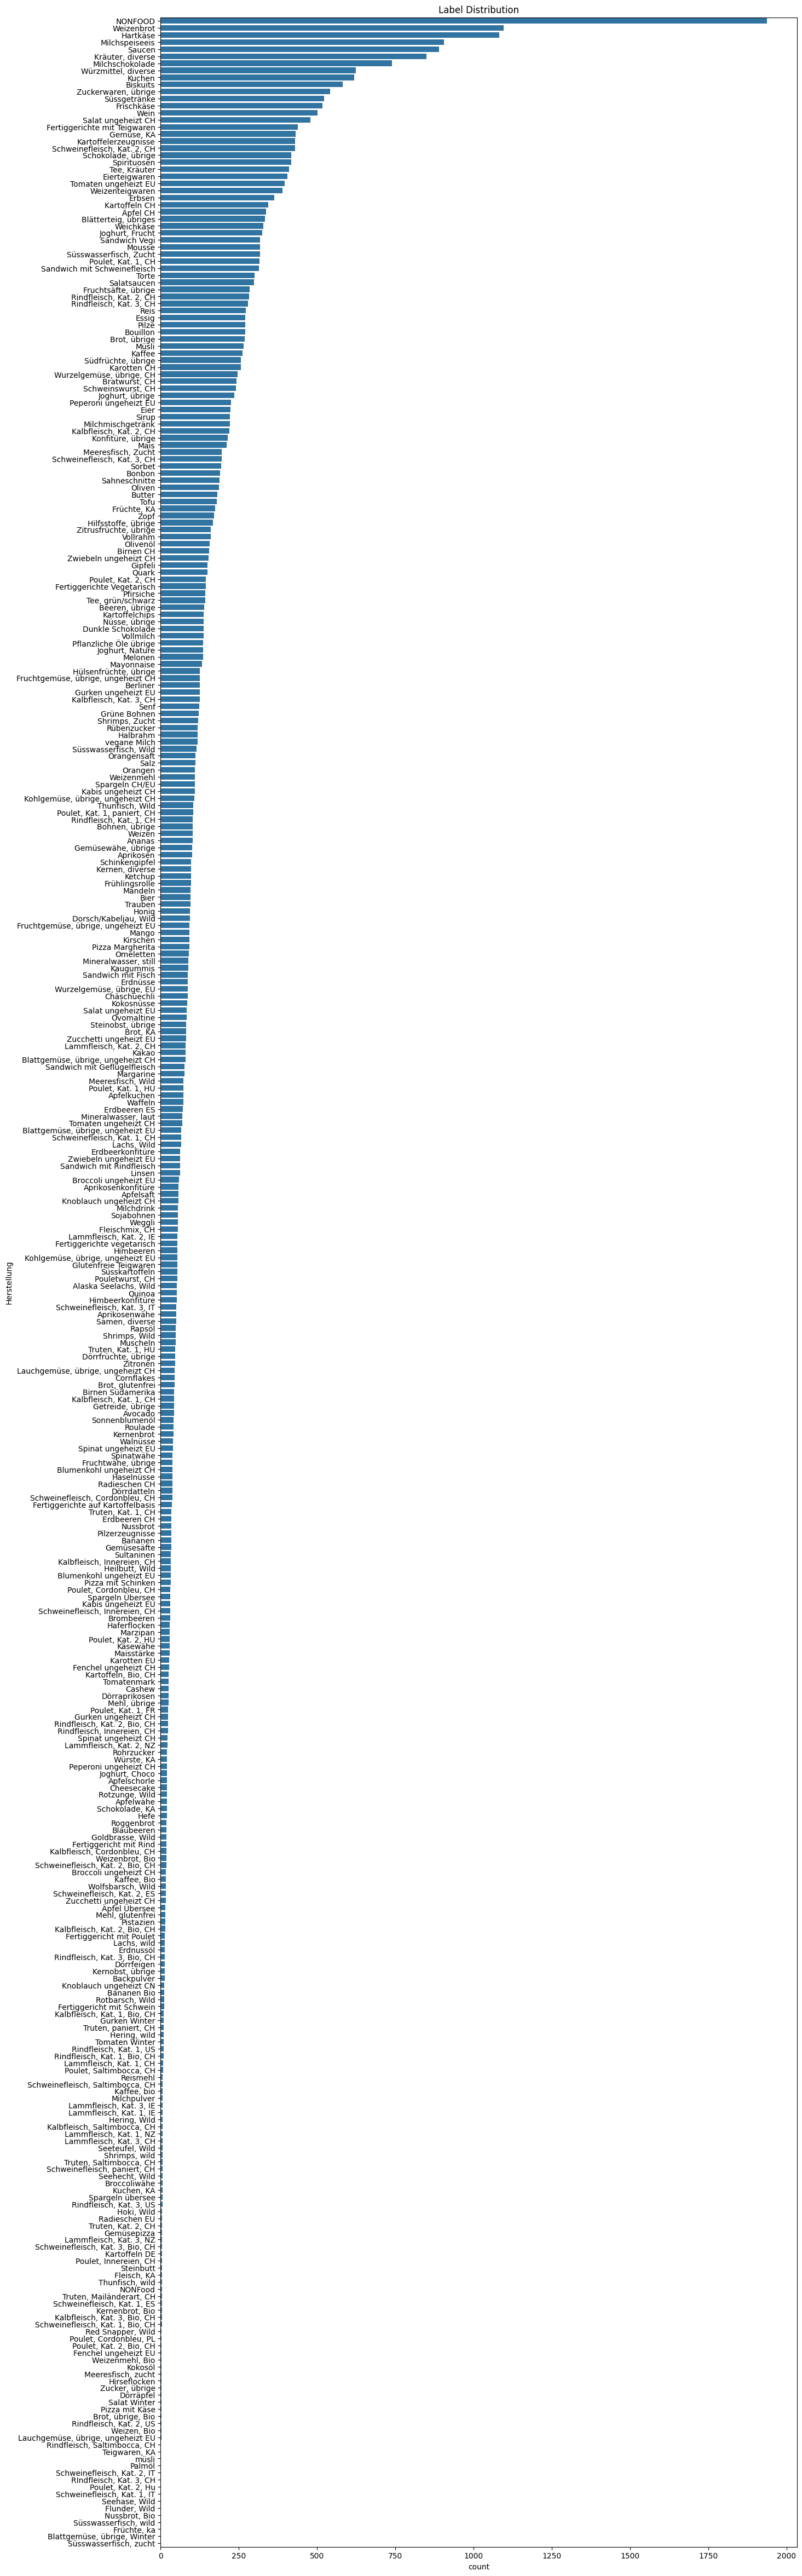

In [35]:
# @title Label Distribution Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot for label distribution
plt.figure(figsize=(15, 60))
sns.countplot(y=df['Herstellung'], order=df['Herstellung'].value_counts().index)
plt.title('Label Distribution')
plt.show()


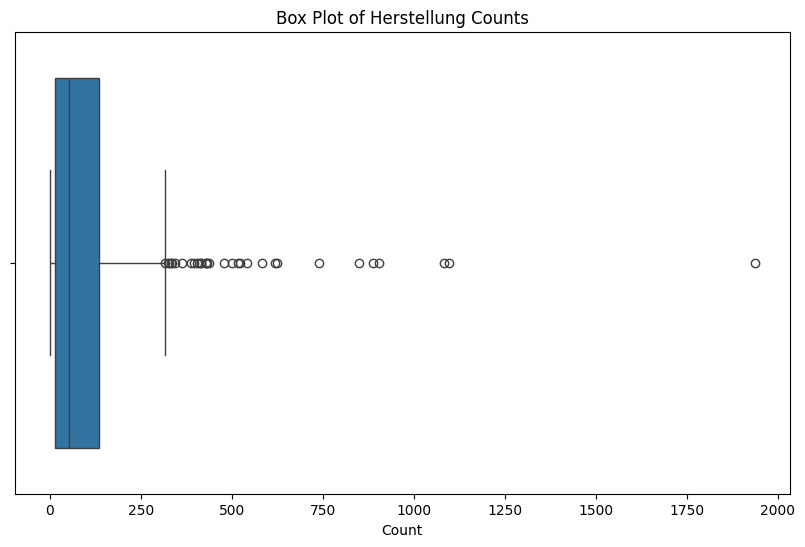

In [16]:
# @title Box plot for 'Herstellung' categories count

import seaborn as sns
import matplotlib.pyplot as plt

# Create a box plot for the counts of the 'Herstellung' column
plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
sns.boxplot(x=df['Herstellung'].value_counts())

# Add title and labels
plt.title('Box Plot of Herstellung Counts')
plt.xlabel('Count')

# Show the plot
plt.show()

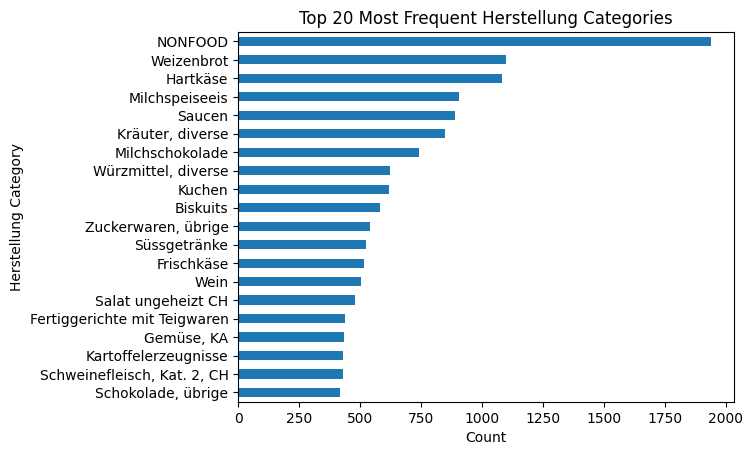

In [17]:
# @title Top 20 Most Frequent Herstellung Categories

import matplotlib.pyplot as plt
import pandas as pd

df['Herstellung'].value_counts().head(20).sort_values().plot(kind='barh')
plt.title('Top 20 Most Frequent Herstellung Categories')
plt.xlabel('Count')
_ = plt.ylabel('Herstellung Category')

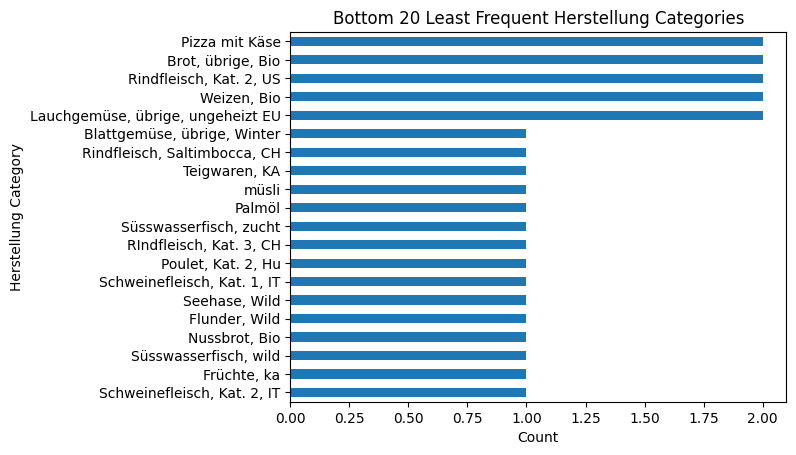

In [36]:
# @title  Bottom 20 Least Frequent Herstellung Categories

import matplotlib.pyplot as plt
import pandas as pd

df['Herstellung'].value_counts().tail(20).sort_values().plot(kind='barh')
plt.title('Bottom 20 Least Frequent Herstellung Categories')
plt.xlabel('Count')
_ = plt.ylabel('Herstellung Category')

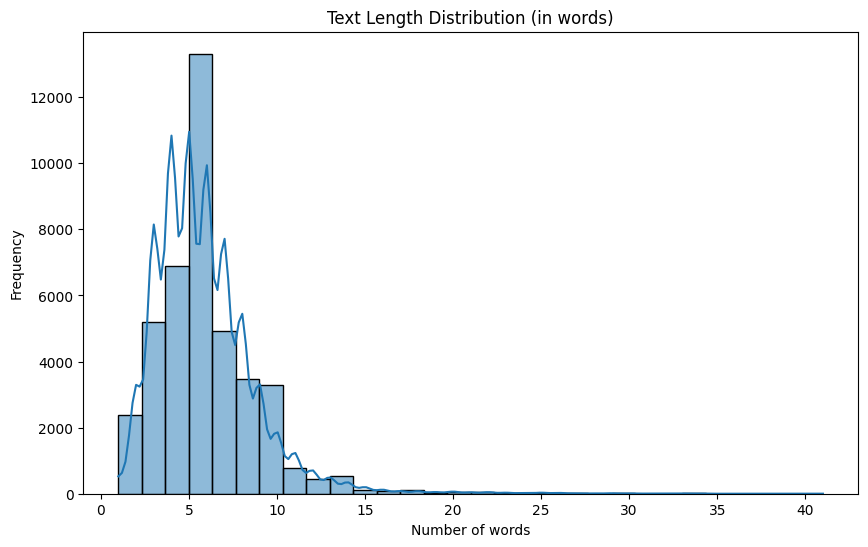

In [28]:
# @title Text Data Length Analysis
df['text_length'] = df['DESCRIPTION'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution (in words)')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()


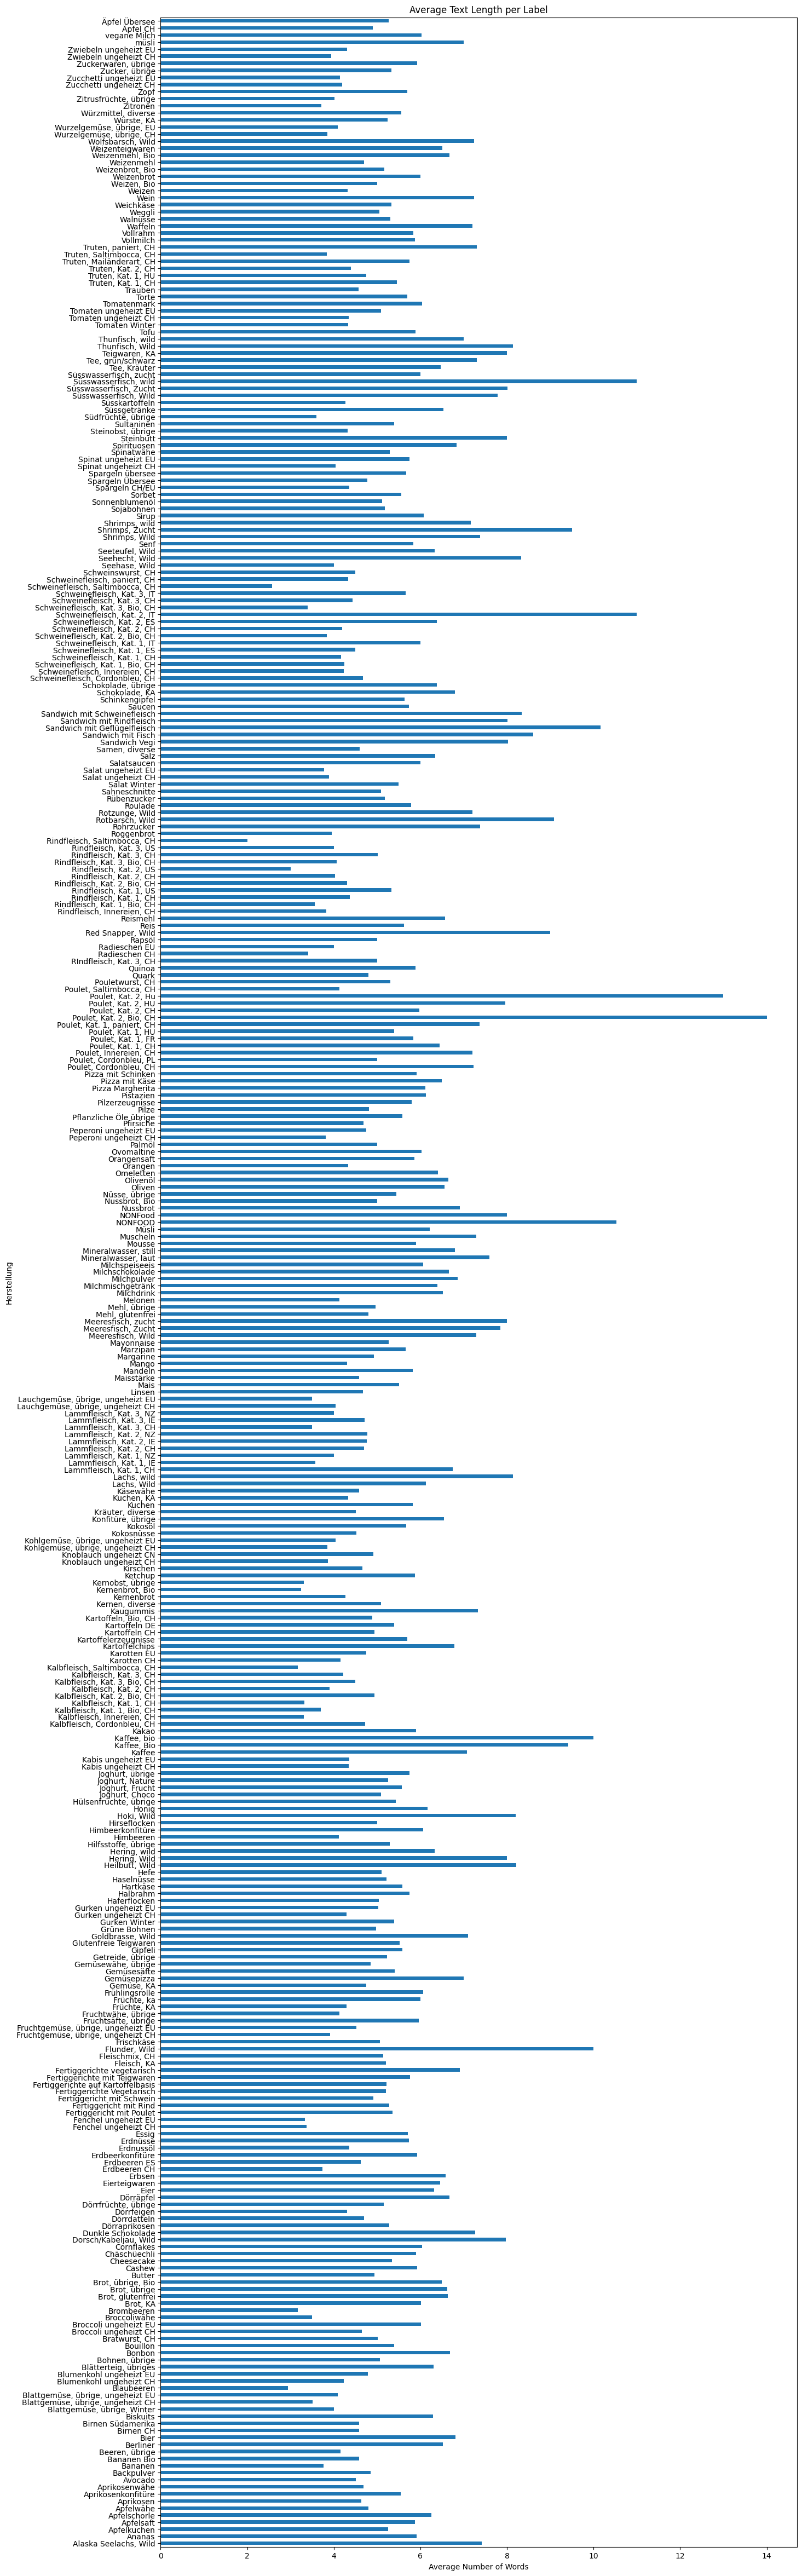

In [37]:
avg_text_length_per_label = df.groupby('Herstellung')['text_length'].mean()
avg_text_length_per_label.plot(kind='barh', figsize=(15, 60))
plt.title('Average Text Length per Label')
plt.xlabel('Average Number of Words')
plt.show()


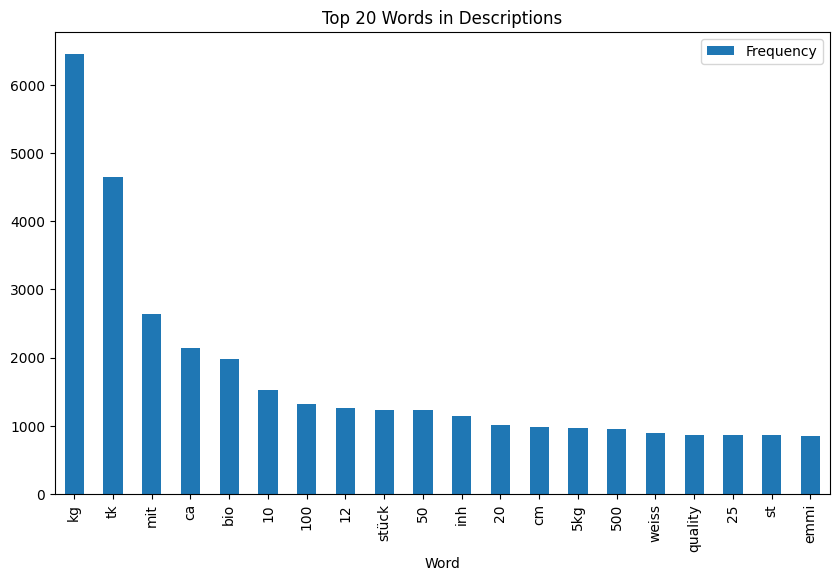

In [38]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_words = get_top_n_words(df['DESCRIPTION'], n=20)
top_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
top_df.plot(kind='bar', x='Word', y='Frequency', figsize=(10, 6), title='Top 20 Words in Description')
plt.show()


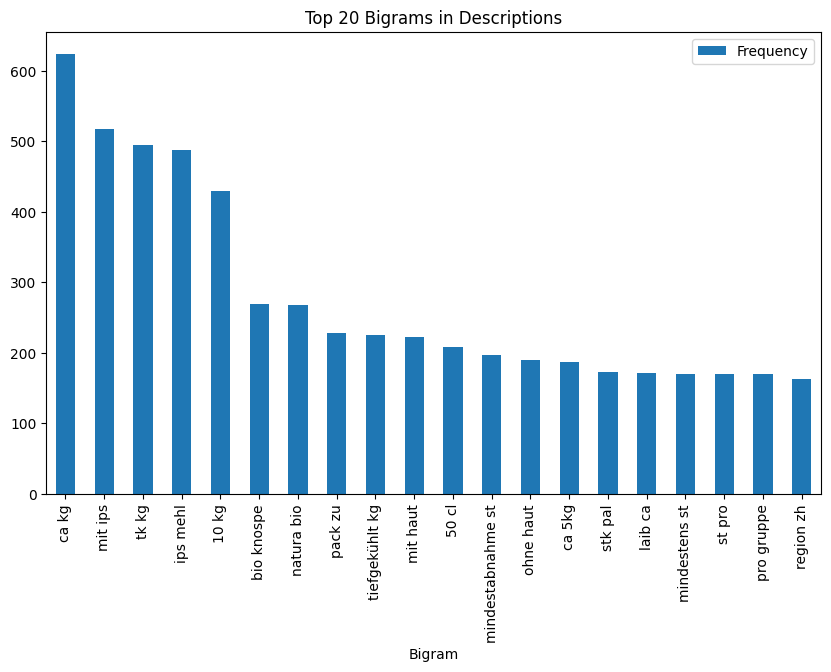

In [39]:
def get_top_n_grams(corpus, n=None, ngram_range=(2, 2)):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_n_grams(df['DESCRIPTION'], n=20, ngram_range=(2, 2))
bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
bigram_df.plot(kind='bar', x='Bigram', y='Frequency', figsize=(10, 6), title='Top 20 Bigrams in Descriptions')
plt.show()

# Data Preprocessing and Cleaning

In [12]:
df.head()

,DESCRIPTION,Herstellung
0,.Smoothfood Brot 48x70g,"Brot, übrige"
1,"""Apfel Boskoop ""Thurgauer""",Äpfel CH
2,"""Aprikosen ""ROUGECOT""",Aprikosen
3,"""Aprikosen ""VANILLACOT""",Aprikosen
4,"""Aprikosen AAA ""Walliser""",Aprikosen


In [14]:
df.describe()

,DESCRIPTION,Herstellung
count,41817,41817
unique,41817,358
top,Zyliss Y-Schäler,NONFOOD
freq,1,1937


In [15]:
# # Get the value counts for each item in DESCRIPTION
# value_counts = df.DESCRIPTION.value_counts()

# # Filter to show only items that appear exactly twice
# items_appearing_twice = value_counts[value_counts == 2]

# #len(items_appearing_twice)
# print(items_appearing_twice)

In [16]:
# From the EDA we notice that the dataset is highly imbalanced, as a first step we reduce the elements from 'NONFOOD' category
df_label = df[df['Herstellung'] == 'NONFOOD']
df_other = df[df['Herstellung'] != 'NONFOOD']

# Randomly sample the specified number of elements from the label's DataFrame
sampled_df_label = df_label.sample(n=1500, random_state=42)

# Combine the sampled elements with the rest of the DataFrame
df_balanced = pd.concat([sampled_df_label, df_other])

# Optional: Shuffle the final DataFrame
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download the stopwords if you haven't done so
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Get the German stop words
stop_words = stopwords.words('german')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/neerajbhauryal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/neerajbhauryal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/neerajbhauryal/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [24]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Removing numbers
    tokens = [word for word in tokens if not word.isdigit()]
    # Removing extra whitespaces
    text = ' '.join(tokens)
    return text
df['DESCRIPTION']= df['DESCRIPTION'].apply(clean_text)
#df['Herstellung']=df['Herstellung'].apply(clean_text)
df['Herstellung']=df['Herstellung'].str.strip().str.lower()

In [25]:
tags=df.Herstellung.unique().tolist()

In [26]:
df.head()

,DESCRIPTION,Herstellung
0,eierspätzli frisch x kg,eierteigwaren
1,bio peperoncini rot,"gemüse, ka"
2,langkornrei parboil gladio x kg,reis
3,oliven schwarz entsteint 850g gudssd,oliven
4,soft pflaumen x g,"dörrfrüchte, übrige"


In [30]:
value_counts = df['Herstellung'].value_counts()

In [32]:
elements_less_than_5 = value_counts[value_counts < 5].index.tolist()
print(elements_less_than_5)

['kalbfleisch, kat. 3, bio, ch', 'kernenbrot, bio', 'schweinefleisch, kat. 1, es', 'truten, mailänderart, ch', 'schweinefleisch, kat. 1, bio, ch', 'weizenmehl, bio', 'fenchel ungeheizt eu', 'poulet, cordonbleu, pl', 'zucker, übrige', 'poulet, kat. 2, bio, ch', 'red snapper, wild', 'kokosöl', 'dörräpfel', 'hirseflocken', 'brot, übrige, bio', 'lauchgemüse, übrige, ungeheizt eu', 'salat winter', 'weizen, bio', 'rindfleisch, kat. 2, us', 'pizza mit käse', 'palmöl', 'flunder, wild', 'teigwaren, ka', 'blattgemüse, übrige, winter', 'schweinefleisch, kat. 2, it', 'nussbrot, bio', 'seehase, wild', 'rindfleisch, saltimbocca, ch', 'schweinefleisch, kat. 1, it']


In [34]:
to_keep = value_counts[value_counts >= 5].index
df = df[df['Herstellung'].isin(to_keep)]

In [36]:
df.Herstellung.value_counts()

Herstellung
nonfood                  1504
weizenbrot               1097
hartkäse                 1083
milchspeiseeis            906
saucen                    889
                         ... 
gemüsepizza                 5
poulet, innereien, ch       5
steinbutt                   5
radieschen eu               5
kartoffeln de               5
Name: count, Length: 314, dtype: int64

In [38]:
df.Herstellung.value_counts().tail(10)

Herstellung
truten, kat. 2, ch                  5
fleisch, ka                         5
schweinefleisch, kat. 3, bio, ch    5
hoki, wild                          5
lammfleisch, kat. 3, nz             5
gemüsepizza                         5
poulet, innereien, ch               5
steinbutt                           5
radieschen eu                       5
kartoffeln de                       5
Name: count, dtype: int64

In [40]:
# Features & Labels
xlabels = df['DESCRIPTION']
ylabels = df['Herstellung']

#Machine Learning Models

# Logistic Regression

In [ ]:
pipeline_lr = Pipeline([('tfidf',TfidfVectorizer(max_features=20000)),
                          ('lr',LogisticRegression(C=10,n_jobs=-1, max_iter=100,solver='liblinear',class_weight='balanced'))])

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Define stratified K-Fold with 5 splits
stratified_kfold = StratifiedKFold(n_splits=5)

# Evaluate using cross-validation with Stratified K-Fold
cv_scores = cross_val_score(pipeline_lr, xlabels, ylabels, cv=stratified_kfold, scoring='accuracy')
print("Stratified K-Fold accuracy scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

Stratified K-Fold accuracy scores: [0.80890718 0.80140385 0.80137981 0.80694747 0.80779472]
Mean accuracy: 0.8052866058817466


In [ ]:
y_pred_cv = cross_val_predict(pipeline_lr, xlabels, ylabels, cv=stratified_kfold)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
print(classification_report(ylabels, y_pred_cv))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                    precision    recall  f1-score   support

             alaska seelachs, wild       0.81      0.83      0.82        52
                            ananas       0.89      0.95      0.92       102
                       apfelkuchen       0.83      0.75      0.79        73
                         apfelsaft       0.88      0.89      0.89        57
                      apfelschorle       0.86      0.95      0.90        20
                         apfelwähe       0.78      0.90      0.84        20
                         aprikosen       0.82      0.91      0.86       100
                aprikosenkonfitüre       0.84      0.75      0.80        57
                     aprikosenwähe       0.78      0.76      0.77        50
                           avocado       0.83      0.91      0.87        43
                        backpulver       0.92      0.92      0.92        13
                           bananen       0.82      0.91      0.86        34
           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
pipeline_lr.predict(["MSC Hoki Royalfilets ohne Haut, 140-160g, lose TK"])

array(['dorsch/kabeljau, wild'], dtype=object)

time: 10 ms (started: 2024-11-11 11:28:27 +01:00)


# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=18000)),
                ('clf', SVC(kernel='linear',C=10, random_state=42,class_weight='balanced')),
               ])

In [ ]:
cv_scores = cross_val_score(svm, xlabels, ylabels, cv=5, scoring='accuracy')
print("Cross-validated accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validated accuracy scores: [0.80366177 0.79848229 0.79243465 0.79375979 0.79845802]
Mean accuracy: 0.7973593026367506


In [ ]:
#y_pred_cv = cross_val_predict(svm, xlabels, ylabels, cv=stratified_kfold)

In [6]:
#print(classification_report(ylabels, y_pred_cv, zero_division=0))

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([
                ('tfidf', TfidfVectorizer(max_features=18000)),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42, max_iter=100, tol=1e-3,class_weight='balanced')),
               ])

In [ ]:
cv_scores = cross_val_score(sgd, xlabels, ylabels, cv=stratified_kfold, scoring='accuracy')
print("Cross-validated accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validated accuracy scores: [0.79944592 0.78667791 0.78496567 0.79147091 0.79339839]
Mean accuracy: 0.7911917570455227


In [8]:
#y_pred_sgd = cross_val_predict(svm, xlabels, ylabels, cv=stratified_kfold)

In [9]:
#print(classification_report(ylabels, y_pred_sgd, zero_division=0))

# Multinomial Naive Bayes

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([
               ('tfidf', TfidfVectorizer(max_features=18000)),
               ('clf', MultinomialNB(alpha=1e-3)),
              ])

NameError: name 'TfidfVectorizer' is not defined

In [ ]:
cv_scores = cross_val_score(nb, xlabels, ylabels, cv=stratified_kfold, scoring='accuracy')
print("Cross-validated accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validated accuracy scores: [0.78348646 0.7783823  0.77451336 0.79168178 0.78479023]
Mean accuracy: 0.7825708261042111


In [10]:
#y_pred_cv = cross_val_predict(nb, xlabels, ylabels, cv=stratified_kfold)

In [11]:
#print(classification_report(ylabels, y_pred_cv, zero_division=0))

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Build the pipeline
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),  # TF-IDF Vectorizer
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced'))   # Random Forest Classifier
])


In [44]:
stratified_kfold = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(pipeline_rf, xlabels, ylabels, cv=stratified_kfold, scoring='accuracy')
print("Cross-validated accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validated accuracy scores: [0.73460002 0.73363185 0.7332365  0.73965142 0.74412975]
Mean accuracy: 0.7370499096616547


In [45]:
# Make predictions
#y_pred_rf = cross_val_predict(pipeline_rf, xlabels, ylabels, cv=stratified_kfold)
#unique_classes = np.unique(np.concatenate([ylabels, y_pred_cv]))

# Display the classification report
#print(classification_report(y_test, y_pred_rf, zero_division=0))

# XGBoost

In [48]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# 2. Fit the encoder on all unique target values to ensure consistent mapping
all_target_values = pd.concat([df['Herstellung']]) # Combine all target values
label_encoder.fit(all_target_values)

LabelEncoder()

In [60]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['DESCRIPTION'], df['Herstellung'], test_size=0.2, random_state=42)

In [62]:
# 4. Transform target variables using the fitted encoder
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [103]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(label_encoder.transform(all_target_values)), y=label_encoder.transform(all_target_values))
class_weight_dict = dict(enumerate(class_weights))
# Map weights to samples
sample_weights = np.array([class_weight_dict[label] for label in y_train_encoded])

In [105]:
from xgboost import XGBClassifier
# Build the pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000)),
    ('xgb', XGBClassifier(objective='multi:softmax',eval_metric='mlogloss', learning_rate=0.05,  random_state=42, n_estimators=300))
])

# Train the model
pipeline_xgb.fit(X_train, y_train_encoded,xgb__sample_weight=sample_weights)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=20000)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [106]:
# Make predictions
y_pred = pipeline_xgb.predict(X_test)

In [107]:
accuracy_score(y_test_encoded, predictions)

0.6578724434224857